<a href="https://www.kaggle.com/code/lostinworlds/sql-london-crime?scriptVersionId=99941660" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Understanding London's Crime statistics using SQL and python.**  

# Introduction
Criminal analysis or intelligence analysis has garnered significant attention in recent years following key achievements in tackling criminality. In this domain, *“analysts study criminal data to identify possible trends, relationships or connections between different crimes in different places, and use the analysis to support law enforcement activities”* (Interpol 2014). One breakthrough in this field emerged after the 2011 London riots (The Guardian 2012) where researchers identified patterns in the riots and the origins of people who were arrested. (Fry 2014) 

Subsequently, in this project, the London crime statistics will be evaluated using SQL. 

# Overview

In the Big Query database hosted by Google, there is a dataset consisting of crimes recorded in London from approx. 2008 to 2011. The dataset holds information on the types of crimes that were committed in various boroughs of London. For those unaware, London is divided into approx. 33 boroughs. They are "*each governed by a council, who decide policies on services like libraries, waste collection and social services*".(Dickinson 2022)

In [1]:
# establish enviorment for python and SQL
from google.cloud import bigquery
client = bigquery.Client() 

# import libraries for handling data 
import numpy as np
import pandas as pd

# library for using Kaggle data 
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# libraries for data visualisation 
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px

# establish function to ensure large queries are not run. All queries here on will use this fuction
def run_query(query): 
    #limiter to ensure that large queries are not used. 
    ONE_MB = 10*1000
    query_job = client.query(query)
    safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=ONE_MB)
    safe_query_job = client.query(query, job_config=safe_config)
    return safe_query_job.to_dataframe()

Using Kaggle's public dataset BigQuery integration.
/kaggle/input/london-population-density/housing-density-borough.csv


In [2]:
# establish client for interacting with london_crim database stored on big query
dataset_ref = client.dataset("london_crime", project = "bigquery-public-data")
dataset = client.get_dataset(dataset_ref)

In [3]:
# list tables in database
tables = list(client.list_tables(dataset))

for table in tables:
    print(table.table_id)

crime_by_lsoa


In [4]:
# query to list first 5 rows of the london_crime, crime by lsoa dataset
query = """SELECT * FROM `bigquery-public-data.london_crime.crime_by_lsoa` LIMIT 5 """

#run query
top_5_rows = run_query(query)

# return results
top_5_rows

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,lsoa_code,borough,major_category,minor_category,value,year,month
0,E01000002,City of London,Violence Against the Person,Harassment,0,2011,9
1,E01000005,City of London,Violence Against the Person,Harassment,0,2014,7
2,E01000001,City of London,Violence Against the Person,Harassment,0,2008,3
3,E01032739,City of London,Violence Against the Person,Harassment,0,2016,3
4,E01000001,City of London,Violence Against the Person,Harassment,0,2011,10


In [5]:
# query for extracting key stats about the dataset 
query = """SELECT count( distinct (borough)) as boroughs, count( distinct (major_category)) as crimes, min(year) as min_year, max(year) as max_year
 FROM `bigquery-public-data.london_crime.crime_by_lsoa`   """

#run query
No_borough = run_query(query)

# print results 
print("Number of boroughs -", No_borough["boroughs"][0])
print("No of major categories of crime -", No_borough["crimes"][0])
print("Earliest recorded year - ",No_borough["min_year"][0]) 
print("Last recorded year - ",No_borough["max_year"][0])

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


Number of boroughs - 33
No of major categories of crime - 9
Earliest recorded year -  2008
Last recorded year -  2016


In [6]:
query = """SELECT  distinct (borough ) 
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
order by borough
"""
#run query
list_borough = run_query(query)

# print results
print("London Boroughs are: \n",", ".join(list_borough["borough"].unique()))

London Boroughs are: 
 Barking and Dagenham, Barnet, Bexley, Brent, Bromley, Camden, City of London, Croydon, Ealing, Enfield, Greenwich, Hackney, Hammersmith and Fulham, Haringey, Harrow, Havering, Hillingdon, Hounslow, Islington, Kensington and Chelsea, Kingston upon Thames, Lambeth, Lewisham, Merton, Newham, Redbridge, Richmond upon Thames, Southwark, Sutton, Tower Hamlets, Waltham Forest, Wandsworth, Westminster


The crimes in this dataset are divided into major and minor categories. Each crime is categorised into one of 8 major and 31 minor types. According to this dataset the most common major crime in London is categorised as “Theft and handling” followed by "Violence against the persons". 

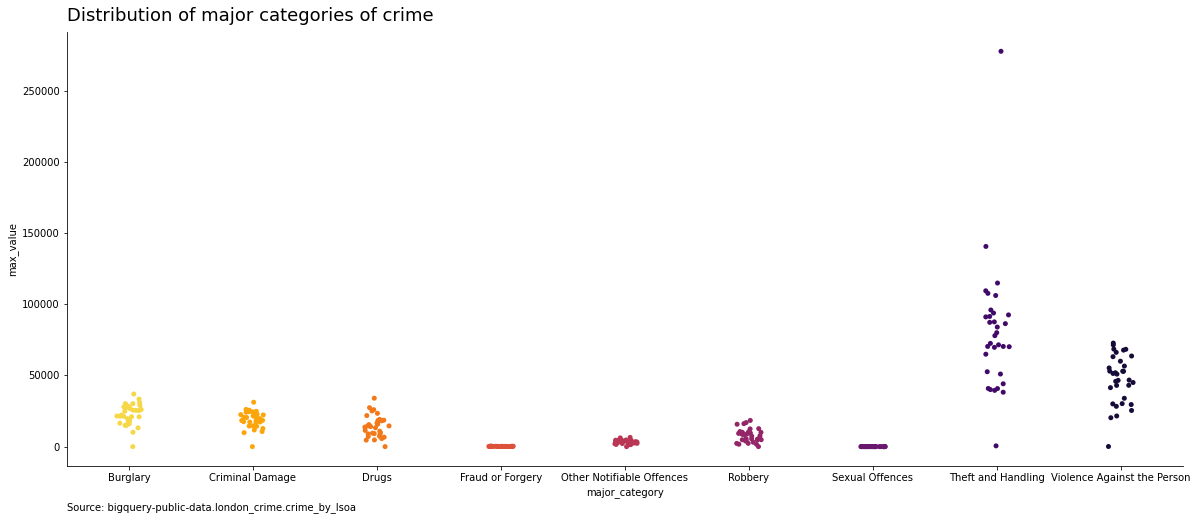

In [7]:
# find total number of crimes per borough and major categories
query = """SELECT   major_category,  borough, sum(value) as max_value, 
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
group by major_category, borough
order by major_category, borough
"""

#run query
crimes_1 = run_query(query)

#create graph
plt.figure(figsize = (20,8))
sns.stripplot(x='major_category', y='max_value', data=crimes_1, palette = "inferno_r")

#Customisation
sns.despine(top = True, right = True, left = False, bottom = False)

plt.title("Distribution of major categories of crime", fontsize = 18, loc='left', y = 1.01)
plt.annotate('Source: bigquery-public-data.london_crime.crime_by_lsoa', (0,-.1), xycoords ='axes fraction')
plt.show()

Comparing this result to that of the data from Chicago indicates that “Theft” may be an issue not specific to London. Although laws and categorisation between Chicago and London vary, Chicago's most common crime is also "Theft". The Chicago crime dataset is also hosted on Big Query and this data was extracted via SQL. 

In [8]:
# establish client and connect to chicago_crime database stored on big query
dataset_ref_1 = client.dataset("chicago_crime", project = "bigquery-public-data")
dataset_1 = client.get_dataset(dataset_ref_1)
tables = list(client.list_tables(dataset_1))

# list tables in database
for table in tables:
    print(table.table_id)

crime


In [9]:
# view fields in the crime dataset
table_ref_1 = dataset_ref_1.table("crime")

table_1 = client.get_table(table_ref_1)

table_1.schema

[SchemaField('unique_key', 'INTEGER', 'REQUIRED', None, (), None),
 SchemaField('case_number', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('date', 'TIMESTAMP', 'NULLABLE', None, (), None),
 SchemaField('block', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('iucr', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('primary_type', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('description', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('location_description', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('arrest', 'BOOLEAN', 'NULLABLE', None, (), None),
 SchemaField('domestic', 'BOOLEAN', 'NULLABLE', None, (), None),
 SchemaField('beat', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('district', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('ward', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('community_area', 'INTEGER', 'NULLABLE', None, (), None),
 SchemaField('fbi_code', 'STRING', 'NULLABLE', None, (), None),
 SchemaField('x_coord

In [10]:
query = """SELECT primary_type, count( primary_type) as count
FROM `bigquery-public-data.chicago_crime.crime` 
group by primary_type
order by count desc
limit 5
"""

#run query
No_crimes_chicago = run_query(query)

#print title and return results
txt =  "Chicago crime data"
title = txt.title()

print(title)

No_crimes_chicago

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


Chicago Crime Data


,primary_type,count
0,THEFT,1594785
1,BATTERY,1389132
2,CRIMINAL DAMAGE,862866
3,NARCOTICS,742949
4,ASSAULT,489751


# Theft and Westminster 
Exploring the overall figures further highlights that the borough of Westminster recorded the highest crime figures between 2008 and 2016, thus accounting for the high point in the strip plot. 

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


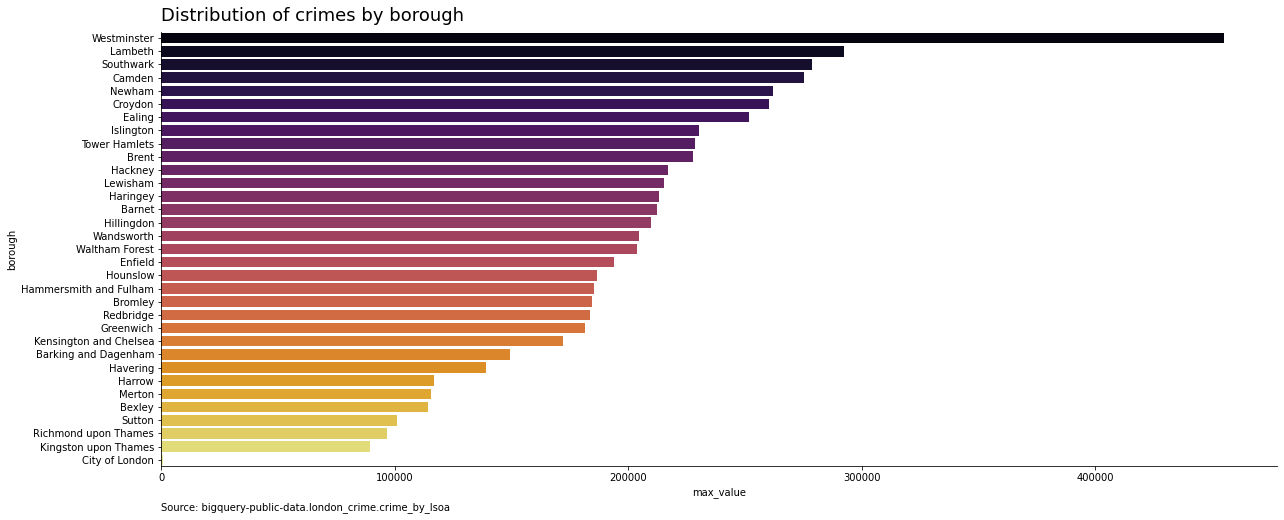

In [11]:
# total number of crimes per borough
query = """SELECT borough, sum(value) as max_value, 
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
group by borough
order by max_value desc
"""

#run query
crimes_1 = run_query(query)

#create graph
plt.figure(figsize = (20,8))
sns.barplot(y='borough', x='max_value', data=crimes_1, palette = "inferno")

#Customisation
sns.despine(top = True, right = True, left = False, bottom = False)

plt.title("Distribution of crimes by borough", fontsize = 18, loc='left', y = 1.01)
plt.annotate('Source: bigquery-public-data.london_crime.crime_by_lsoa', (0,-.1), xycoords ='axes fraction')
plt.show()

The nature of theft and handling in Westminster appears to be categorised as "Other theft". 

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


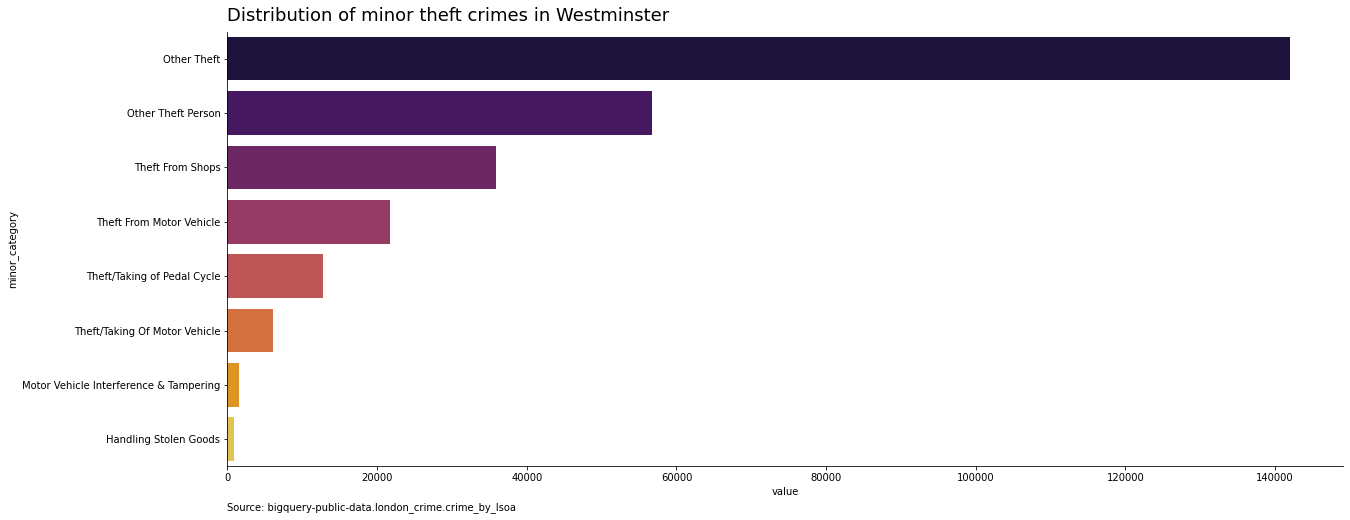

In [12]:
# find total number of crimes for minor theft and handling incidents
query = """SELECT minor_category, sum(value) as value
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
where borough = "Westminster" AND major_category = "Theft and Handling"
group by minor_category
order by value desc"""

#run query
Westminster_crime = run_query(query)

#create graph
plt.figure(figsize = (20,8))
sns.barplot(y='minor_category', x='value', data=Westminster_crime, palette = "inferno")

#Customisation
sns.despine(top = True, right = True, left = False, bottom = False)

plt.title("Distribution of minor theft crimes in Westminster", fontsize = 18, loc='left', y = 1.01)
plt.annotate('Source: bigquery-public-data.london_crime.crime_by_lsoa', (0,-.1), xycoords ='axes fraction')
plt.show()

Whilst this indicates that Westminster has an issue with theft and handling, over time, it appears that the rate of theft has undergone some changes. In general, there are around 2500 and 3000 incidents of theft in the borough. However in 2012, the rates of such crimes peaked significantly, recording around 3500 incidents. However, since 2013, the rates have seen a significant drop and by 2015 the rate dropped to approx. 2000 incidents. 

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


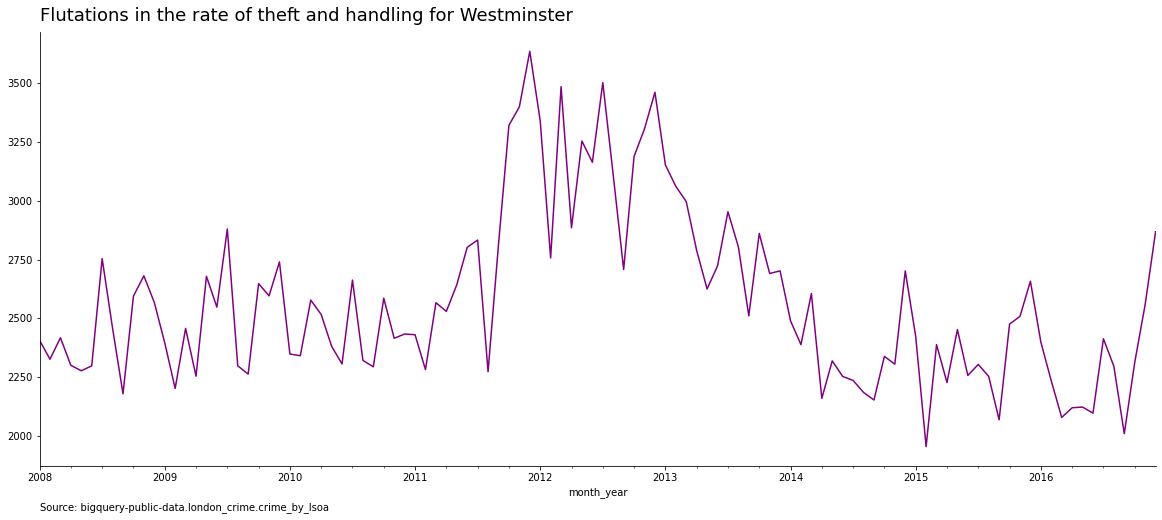

In [13]:
# find month_year total theft and handling rates for Westminster 
query = """SELECT  parse_date("%m-%Y", concat(cast(format("%02d", month) as string),"-",  cast(year as string))) as month_year, sum(value) as value
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
where borough = "Westminster" AND major_category = "Theft and Handling"
group by month_year 
order by month_year
"""

#run query
Westminster_Theft_trend = run_query(query)

#create graph
Westminster_Theft_trend["month_year"] = pd.to_datetime(Westminster_Theft_trend["month_year"])
Westminster_Theft_trend.set_index("month_year",inplace = True)
Westminster_Theft_trend["value"].plot(figsize = (20,8), color = "purple")

#Customisation
sns.despine(top = True, right = True, left = False, bottom = False)

plt.title("Flutations in the rate of theft and handling for Westminster", fontsize = 18, loc='left', y = 1.01)

plt.annotate('Source: bigquery-public-data.london_crime.crime_by_lsoa', (0,-.1), xycoords ='axes fraction')
plt.show()

Alas, it is unclear what may have caused the change in criminality and could include increased policing, new preventative strategies. Such preventative strategies may include hotspot mapping, where targeted policing is applied based on analysis of crime patterns. (Chainey, Tompson, and Uhlig 2008).

However as the book, Freakonomics highlights, crime can be affected by wider factors such as abortion rates (Dubner and Levitt 2006). Therefore, one may assume that the population and economic changes may also be contributing factors.

# Theft in Westminster & the surrounding areas 

Typically, such wider factors have a long term impact on crime and the general impact should also be generalised. That said, there was a major change in the demography of London and specifically the tourist heavy hotspot for boroughs such as Westminster in 2012 - The London Olympics (International Olympic Committee 2012). This may explain the 2012 spike. As for the decline, if the previously mentioned study by UCL is applicable, policing increased and therefore the rates of theft may have dropped.

Adding the theft and handling rates of neighbouring boroughs, shows the following: 

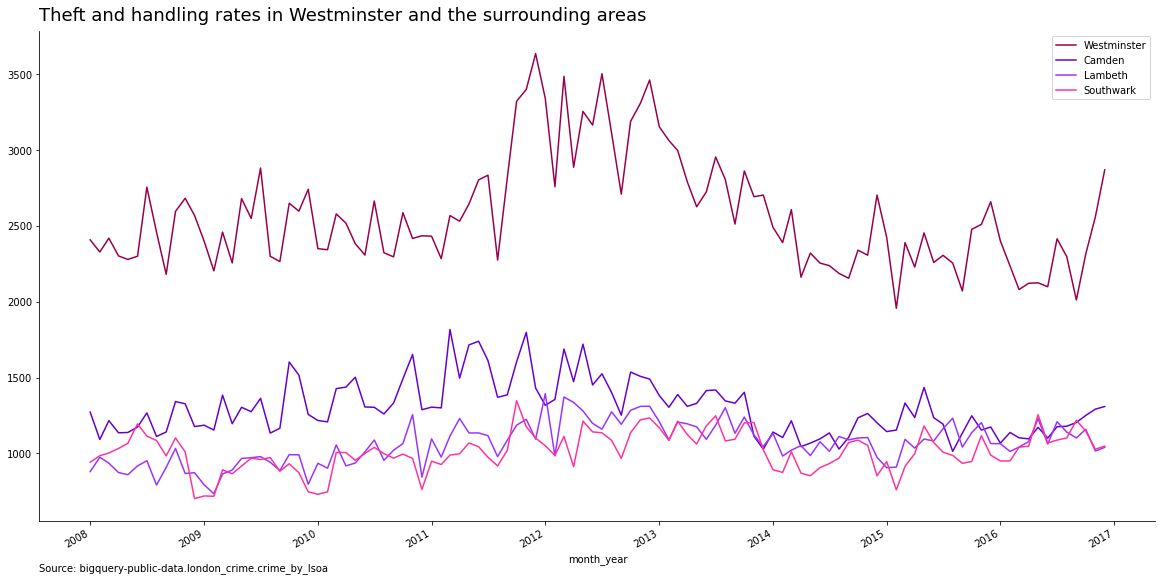

In [14]:
# establish pivot table for theft and handling rates for boroughs around Westminister 
query = """select *
from
 (SELECT  parse_date("%m-%Y", concat(cast(format("%02d", month) as string),"-",  cast(year as string))) as month_year, borough, value
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
where borough in ("Westminster", "Camden","Lambeth","Southwark") AND major_category = "Theft and Handling"
order by month_year) 
pivot (sum(value) for borough in ("Westminster", "Camden","Lambeth","Southwark") )

"""

#run query
Theft_areas = run_query(query)

#update month_year variable to datetime
Theft_areas["month_year"] = pd.to_datetime(Theft_areas["month_year"])
Theft_areas.set_index("month_year",inplace = True)

#create graph
Theft_areas["Westminster"].plot.line(figsize =(20,10), label = "Westminster", color = "#99004C").legend(loc='upper right')
Theft_areas["Camden"].plot.line(label ="Camden", color = "#6600CC").legend(loc='upper right')
Theft_areas["Lambeth"].plot.line(label ="Lambeth", color = "#9933FF").legend(loc='upper right')
Theft_areas["Southwark"].plot.line(label ="Southwark", color = "#FF3399").legend(loc='upper right')

#Customisation
plt.title("Theft and handling rates in Westminster and the surrounding areas", fontsize = 18, loc='left', y = 1.01)
sns.despine(top = True, right = True, left = False, bottom = False)

plt.annotate('Source: bigquery-public-data.london_crime.crime_by_lsoa', (0,-.1), xycoords ='axes fraction')

plt.show()

It indicates that in the months before the peak in Westminster, the crime rates particularly in Camden were rising. This suggest that crime from Camden may have moved to Westminster where it found a sweet spot and thus the 2012 spike in Westminster.  Also as crime began to be tackled, rates in Camden followed by Westminster began to fall. However, this is speculation and further research is required to validate this assumption. 

Sadly, it appears that the rates of crime in Lambeth and Southwark may be steadily increasing from 2009.

Plotting the fluctuating theft rates for each borough, highlights the following graph. It shows the scale of the issue in Westminster. as the majority of the rates in other boroughs fluctuate around 300 and 1000 incidents. Juxtaposing Westminster is City of London, which has an extremely low rate, in most occasions in single figures. 

In [15]:
# establish month_year variable, and find total theft and handling incidents for month_year and borough 
query = """SELECT   parse_date("%m-%Y", concat(cast(format("%02d", month) as string),"-",  cast(year as string))) as month_year, borough, sum(value) as value
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
where major_category = "Theft and Handling"
group by month_year, borough
order by month_year
"""

#run query
Theft = run_query(query)

# revise month_year to a datetime variable
Theft["month_year"] = pd.to_datetime(Theft["month_year"])

#create graph
fig = px.line(Theft, x ="month_year", y = "value", color = "borough", title = "Flutuations in the rate of theft and handling for each borough" )

#Customisation
fig.add_hline(0, line_width = 1, line_dash = "dot")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',
})
fig.update_xaxes(showline=True, linewidth=1, linecolor='black')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')

fig.add_annotation(
    text = ("Source: bigquery-public-data.london_crime.crime_by_lsoa"), showarrow=False, x = 0, y = -0.15
    , xref='paper', yref='paper', xanchor='left', yanchor='bottom', xshift=-1, yshift=-5
    , font=dict(size=10, color="grey"), align="left")

fig.show()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


That said, in total theft and handling remains an issue for the City of London compared to all other forms of major category of crime. 

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



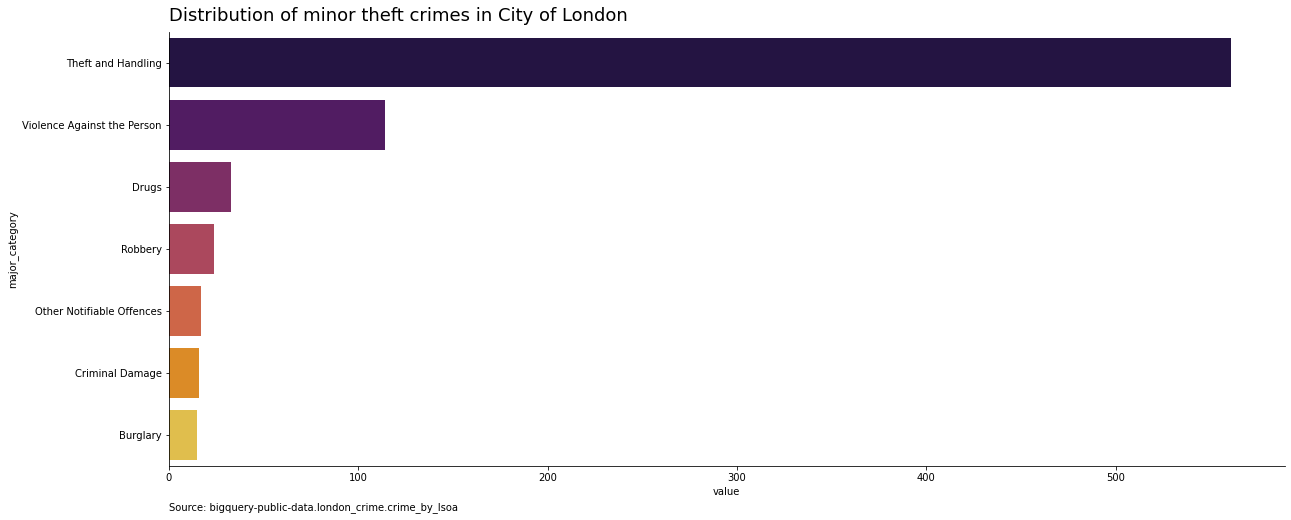

In [16]:
#list major cimes and total values in dataset
query = """SELECT major_category, sum(value) as value
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
where borough = "City of London" 
group by major_category
order by value desc"""

#run query
City_crime = run_query(query)

#create graph
plt.figure(figsize = (20,8))
sns.barplot(y='major_category', x='value', data=City_crime, palette = "inferno")

#Customisation
sns.despine(top = True, right = True, left = False, bottom = False)
plt.title("Distribution of minor theft crimes in City of London", fontsize = 18, loc='left', y = 1.01)
plt.annotate('Source: bigquery-public-data.london_crime.crime_by_lsoa', (0,-.1), xycoords ='axes fraction')
plt.show()

# Crime and population density
Whilst the previous graph provides a comparison theft between the boroughs, it fails to account for any differences between them. For instance, every borough does not have the same population or cover a similar area. 

That said, as this dataset does not hold population data, the data needs to be merged with a secondary data. In doing so using the data from the [London Datastore](https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough), the crime rate with regards to the population density can be established. For reference, on average, the borough of Kensington and Chelsea and Islington has the highest population density whilst Havering and Bromley are the most sparsely populated boroughs. 

In [17]:
#view density dataset
df = pd.read_csv("../input/london-population-density/housing-density-borough.csv")
df.head()

,Code,Name,Year,Source,Population,Inland_Area _Hectares,Total_Area_Hectares,Population_per_hectare,Square_Kilometres,Population_per_square_kilometre
0,E09000001,City of London,1999,ONS MYE,6581,290.4,314.9,22.7,2.9,2266.2
1,E09000001,City of London,2000,ONS MYE,7014,290.4,314.9,24.2,2.9,2415.3
2,E09000001,City of London,2001,ONS MYE,7359,290.4,314.9,25.3,2.9,2534.1
3,E09000001,City of London,2002,ONS MYE,7280,290.4,314.9,25.1,2.9,2506.9
4,E09000001,City of London,2003,ONS MYE,7115,290.4,314.9,24.5,2.9,2450.1


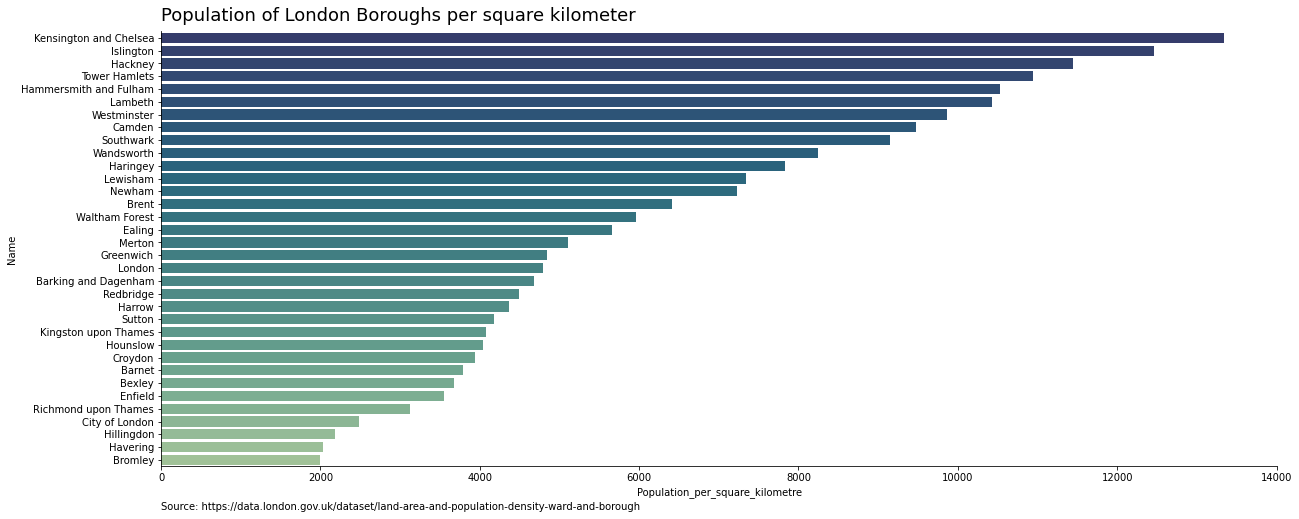

In [18]:
# keep only ONS results
pop = df[df["Source"]=="ONS MYE"]

# keep only name, year and Population_per_square_kilometre variables
sqk = pop[["Name", "Year","Population_per_square_kilometre"]]

# drop region results and sort data by Population_per_square_kilometre
sqk_rev1  = sqk[~sqk["Name"].isin(["Greater London", "Inner London", "Outer London"])].sort_values("Population_per_square_kilometre", ascending = False)

# group by borough and find average Population_per_square_kilometre per borough
sqk_rev1_group = sqk_rev1.groupby("Name")["Population_per_square_kilometre"].mean().reset_index(name = "Population_per_square_kilometre")
sqk_rev1_group.sort_values(by =  "Population_per_square_kilometre",ascending = False,  inplace = True)

#create graph
plt.figure(figsize = (20,8))
sns.barplot(x = "Population_per_square_kilometre", y ="Name", data =   sqk_rev1_group, palette = "crest_r")

#Customisation
sns.despine(top = True, right = True, left = False, bottom = False)
plt.title("Population of London Boroughs per square kilometer", fontsize = 18, loc='left', y = 1.01)
plt.annotate('Source: https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough', (0,-.1), xycoords ='axes fraction')
plt.show()

Calculating yearly theft and handling for each borough and then the ratio of the crime against the population, indicates that Bromley and Hillingdon has the highest theft ratio. This suggest that simply because an area is densely populated does not mean that the area will have a high rate of crime, perhaps because such high populations are also policed by more officers. 

In [19]:
# find total incidences of theft and handling by year and borough
query = """SELECT  year,borough, sum(value) as value
FROM `bigquery-public-data.london_crime.crime_by_lsoa` 
where major_category = "Theft and Handling"
group by year, borough
order by year
"""

#run query
Theft = run_query(query)

# join theft data and population data on borough and year
theft_pop = pd.merge(Theft, sqk_rev1, left_on = ["borough","year"], right_on = ["Name","Year"])

# drop duplicated variables
theft_pop.drop(["year","Name" ], axis = 1, inplace = True)

# calcuate theft ration 
theft_pop["Theft_ratio"] = theft_pop["value"]/theft_pop["Population_per_square_kilometre"]

#create graph
fig = px.line(theft_pop, x ="Year", y = "Theft_ratio", color = "borough", title = "Theft and handling vs population density over time for each borough" )


#Customisation
fig.add_hline(0, line_width = 1, line_dash = "dot")
fig.update_layout({
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)',})
fig.update_xaxes(showline=True, linewidth=1, linecolor='black', tickformat=',g,d')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black')
fig.add_annotation(
    text = ("Source: complied from bigquery-public-data.london_crime.crime_by_lsoa and https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough "), showarrow=False, x = 0, y = -0.15
    , xref='paper', yref='paper', xanchor='left', yanchor='bottom', xshift=-1, yshift=-5
    , font=dict(size=10, color="grey"), align="left")


fig.show()

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning:

Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.



# Conclusion 
This was a SQL project examining the crime statistics in London. As it highlights similar to other cities, London has a particular issue with theft and handling. This is felt most acutely in the borough of Westminster. However, whilst its rate of theft remains high, following a peak in 2012, the rate appears to have fallen. In addition, there seems to be a relationship between the theft levels in Camden and Westminster, as in the months before Westminster's crime rate peaked, Camden's crime rates also hit its all time high. 

Finally, each borough covers different area and service different populations. Taking these aspects into account highlights population alone does not explain high rates of crime, particularly for theft. 

# References
* Chainey, Spencer, Lisa Tompson, and Sebastian Uhlig. 2008. “The utility of hotspot mapping for predicting spatial patterns of crime.” Security Journal (pre-print copy). https://discovery.ucl.ac.uk/id/eprint/112873/1/PREPRINT_-_Chainey,_Tompson_&_Uhlig_2008.pdf.

* Dickinson, Sophie. 2022. “How many boroughs does London have and what are they?” Metro, May 5, 2022. https://metro.co.uk/2021/04/06/how-many-boroughs-does-london-have-and-what-are-they-14343910/.

* Dubner, Stephen J., and Steven D. Levitt. 2006. Freakonomics: A Rogue Economist Explores the Hidden Side of Everything. Edited by Stephen J. Dubner. N.p.: Penguin Books Limited.

* Fry, Hannah. 2014. “re:publica 2014 - Hannah Fry: I predict a riot!” YouTube. https://www.youtube.com/watch?v=ROnjZDdt8O8.

* The Guardian. 2012. “Reading the London Riots: 'I have no doubt the riots will happen again.'” YouTube. https://www.youtube.com/watch?v=IF_AC0n_zjk&feature=youtu.be.

* International Olympic Committee. 2012. “London 2012 Summer Olympics - Athletes, Medals & Results.” Olympics. https://olympics.com/en/olympic-games/london-2012.

* Interpol. 2014. “Criminal intelligence analysis.” file:///C:/Users/melli/Downloads/27_CAS01_05_2014_EN_web.pdf.

* London Datastore. 2018. “Datasets Land Area and Population Density, Ward and Borough.” London Datastore. https://data.london.gov.uk/dataset/land-area-and-population-density-ward-and-borough.




*Author's notes: Sadly I had some major issues related to using Kaggle and working with Python and SQL. This caused a myriad of issues resulting in the early termination of the project.* 